In [1]:
import warnings
warnings.filterwarnings("ignore")

# Importing GemPy
import gempy as gp
from gempy.assets import topology as tp
from gempy.bayesian.fields import compute_prob, calculate_ie_masked
from gempy.assets.geophysics import GravityPreprocessing

# Importing auxilary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# For embedding matplotlib figures
#%matplotlib qt5
%matplotlib inline

# Import improved plotting features
from gempy.plot import visualization_2d as vv
from gempy.plot import vista

import seaborn as sn

In [2]:
print(f"Code run with GemPy version: {gp.__version__}")

Code run with GemPy version: 2.2.9


In [3]:
## progress bar
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# Model Initialization
First, we import the base Proof-of-Concept model (POC-model from here on), which was generated in the previous example. Using the loading method of GemPy `gp.load_model()` directly loads the model's input, already set with fault relations, surfaces assigned to a stack (series), etc.
Only thing left is to recompile and run the model.

In [4]:
# With GemPy 2.2.9
model_path = '../models/2021-06-04_POC_base_model'

geo_model = gp.load_model('POC_PCT_model', path=model_path,
                         recompile=False)

# import DTM
dtm = np.load('../models/20210319_MC_no_middle_filling/Graben_base_model/Graben_base_model_topography.npy')

Active grids: ['regular']
Active grids: ['regular' 'topography']


Using the method `.get_additional_data()`, we can display a summary of model information and parameters, such as the kriging parameters.

In [5]:
geo_model.get_additional_data()

values
Structure isLith                                                          True
          isFault                                                         True
          number faults                                                      5
          number surfaces                                                   11
          number series                                                     10
          number surfaces per series            [1, 1, 1, 1, 1, 3, 1, 1, 1, 0]
          len surfaces surface_points  [6, 8, 12, 8, 6, 8, 14, 14, 26, 24, 24]
          len series surface_points        [6, 8, 12, 8, 6, 36, 26, 24, 24, 0]
          len series orientations           [2, 2, 6, 4, 2, 12, 16, 12, 10, 0]
Options   dtype                                                        float64
          output                                                       geology
          theano_optimizer                                        fast_compile
          device                                                           cpu
          verbosity                                                       None
Kriging   range                                                        32190.8
          $C_o$                                                    2.46726e+07
          drift equations                       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Rescaling rescaling factor                                             56916.7
          centers                          [14239.166495, 6900.0, -2581.92853]

Changing the kriging parameters affects the resulting models, e.g. the range represents the maximum correlation distance, or reducing the coefficient of correlation will yield a smoother, less "bumpy" model. For the POC-model, we set the `range` to 20000 and the correlation coefficient $C_o$ to 200000. Then we set up the interpolator, i.e. compile the functions which will calculate the scalar fields of our model surfaces.

In [6]:
# adapt kriging to the parameters of previous example
# decrease the kriging range
geo_model.modify_kriging_parameters('range', 20000.)
geo_model.modify_kriging_parameters('$C_o$', 2e5)
#geo_model.modify_surface_points('all', smooth=1e-6)

# Set the interpolator function
# Create the theano model
gp.set_interpolator(geo_model,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[],
                         update_kriging=False);

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  5
Compilation Done!
Kriging values: 
                                          values
range                                     20000
$C_o$                                    200000
drift equations  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [9]:
# Compute the model
sol = gp.compute_model(geo_model, compute_mesh=True)

Now that the model is computed, lets have a look at a cross-section along the y-axis, so across the graben system:

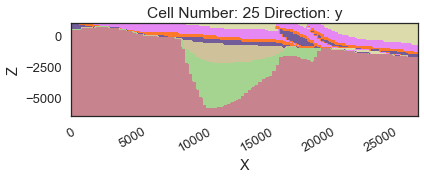

In [10]:
gp.plot_2d(geo_model, cell_number=25, direction='y', show_data=False, show_topography=False,
          show_lith=True, show_results=True, show_boundaries=False);

The two distinct domains in this model are directly visible: (i) the old graben system (extensional regime), covered by the (ii) thrusted, younger units.

## Add Gravity grid
In the previous example, next to creating the model, we chose quasi-random locations for 15 gravity stations. The gravity signal of the base POC-model is simulated at these 15 stations. In the following workflows, we assume that these 15 stations were measured. So they serve as observed data for conditioning the MonteCarlo Ensemble of different geological geometries.

In [14]:
grav_stations = pd.read_csv('../models/20210319_MC_no_middle_filling/2021-06-16_grav_of_POC_base_model.csv')
station_coordinates = np.stack((grav_stations.X.values, 
                                grav_stations.Y.values, 
                                grav_stations.Z.values), axis=1)

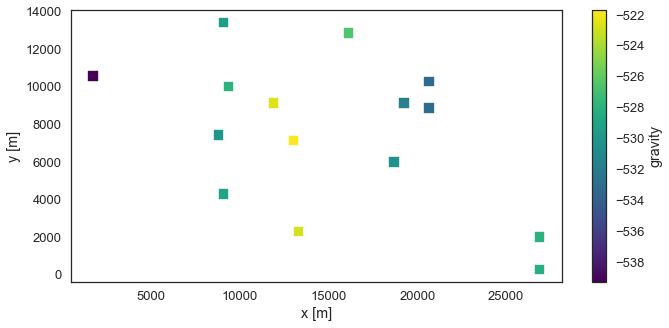

In [15]:
fig = plt.figure(figsize=[11,5])
cb = plt.scatter(grav_stations['X'], grav_stations['Y'], c=grav_stations['grav'], 
           marker='s', s=90, cmap='viridis')
plt.colorbar(cb, label='gravity')
plt.ylabel('y [m]')
plt.xlabel('x [m]');

These stations are used for creating a centered grid around each station. The centered grid has an extent of 10 cells in x- and y-direction, and 15 cells in the z-direction.

In [16]:
geo_model.set_centered_grid(station_coordinates,  resolution = [10, 10, 15], radius=6000)
#g = GravityPreprocessing(geo_model.grid.centered_grid)
#tz = g.set_tz_kernel()

Active grids: ['regular' 'topography' 'centered']


Grid Object. Values: 
array([[  140.        ,   140.        , -6437.5       ],
       [  140.        ,   140.        , -6312.5       ],
       [  140.        ,   140.        , -6187.5       ],
       ...,
       [32868.69      ,  6285.71      , -3371.87176905],
       [32868.69      ,  6285.71      , -4824.38684561],
       [32868.69      ,  6285.71      , -6842.65      ]])

We see that there are three active grids. On each, the gravity signal will be calculated. Of course, we can let it be calculated on each grid, but we may not need the information on e.g. the topography grid (which would for instance yield the geological map). 
So we can set only the centered grid to active, which speeds up the simulation.

**Note** that you'll need to model also the regular grid, if you plan to export the `lith_block` geological voxel model later on! 
As we want to also have the geometric changes in the lithological grid, we set `reset=False`. If we were to set it to `True`, only the 'centered' grid would be active.

In [17]:
geo_model.set_active_grid('centered', reset=False)

Active grids: ['regular' 'topography' 'centered']


Grid Object. Values: 
array([[  140.        ,   140.        , -6437.5       ],
       [  140.        ,   140.        , -6312.5       ],
       [  140.        ,   140.        , -6187.5       ],
       ...,
       [32868.69      ,  6285.71      , -3371.87176905],
       [32868.69      ,  6285.71      , -4824.38684561],
       [32868.69      ,  6285.71      , -6842.65      ]])

The centered grid will now be the only one where the model information is stored, meaning less computational time. Let's have a look how this comes in handy, when we start to modify the depth of units and calculate the gravity.

Before running the simulations, we need to assign densities to the rock units, otherwise it will raise an error.

In [18]:
# add densities - from abdelfettah 2014 and SAPHYR
densities = [0, 0, 0, 0, 0, 2.466, 2.61, 2.53, 
             2.61, 2.47, 2.55, 2.67]
geo_model.add_surface_values(densities, ['density'])

,surface,series,order_surfaces,color,id,density
9,Thrust1_south,Thrust1_series,1,#5DA629,1,0.000000
10,Thrust2_south,Thrust2_series,1,#5DA629,2,0.000000
0,Fault2,Fault2_series,1,#015482,3,0.000000
1,Fault5,Fault5_series,1,#015482,4,0.000000
2,Fault6,Fault6_series,1,#015482,5,0.000000
6,Tertiary,Post_tectonic_series,1,#dbdbac,6,2.466000
8,Pink,Post_tectonic_series,2,#e588f3,7,2.610000
7,Orange,Post_tectonic_series,3,#ff792b,8,2.530000
5,Unconformity,Detachement,1,#725c9a,9,2.610000
4,Upper-filling,Syn_tectonic_series2,1,#cfc199,10,2.470000


## MC Variation
For varying the depth of units, we extract the indices of the units whose input points we want to modify. To guarantee that we always vary the original depth in each realization (and not the depth used in the previous realization), we first generate an initial-depth array, containing the original depth information of all input points:

In [20]:
Z_init = geo_model.surface_points.df['Z'].copy()
X_init = geo_model.surface_points.df['X'].copy()

Having all the undisturbed depth values, we extract all surface points belonging to the units whose inputs we want to vary:

In [23]:
graben_lower = geo_model.surface_points.df.query("surface=='Lower-filling'")
graben_middle = geo_model.surface_points.df.query("surface=='Upper-filling'")
unconformity = geo_model.surface_points.df.query("surface=='Unconformity'")
fault_two = geo_model.surface_points.df.query("surface=='Fault2'")

Before running the Monte Carlo simulations, we set up the interpolator for a "fast-run", i.e. it optimizes runtime on cost of compilation time:

In [24]:
gp.set_interpolator(geo_model, output=['gravity'], 
                    theano_optimizer='fast_run', 
                    update_kriging=True)

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  5
Compilation Done!
Kriging values: 
                                          values
range                                   32190.8
$C_o$                               2.46726e+07
drift equations  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [29]:
%%time
np.random.seed(1)
# allocate array for lithology blocks
lith_blocks = np.array([])
# create a dictionary to store gravity of simulations
grav = dict() 
# get indices where the variable input points are
Lgraben = list(graben_lower.index)
Ugraben = list(graben_middle.index)
Uncon = list(unconformity.index)
Fault = list(fault_two.index)
Cindices = Lgraben + Ugraben + Uncon

# set number of realizations
n_iterations = 500

for i in log_progress(range(n_iterations), name='Models'):
    # vary surface points
    Z_var = np.random.normal(0, 300, size=3)
    Z_loc = np.hstack([Z_init[Lgraben] + Z_var[0],
                   Z_init[Ugraben] + Z_var[1],
                   Z_init[Uncon] + Z_var[2]])
    X_loc = X_init[Fault] + np.random.normal(0, 300)
    # apply variation to model
    geo_model.modify_surface_points(Cindices, Z=Z_loc)
    geo_model.modify_surface_points(Fault, X=X_loc)
    # re-compute model
    gp.compute_model(geo_model)
    # store lithologies ONLY THERE IF REGULAR GRID IS ACTIVE
    lith_blocks = np.append(lith_blocks, geo_model.solutions.lith_block)
    # store gravity
    grav[f"Real_{i}"] = geo_model.solutions.fw_gravity
    

lith_blocks = lith_blocks.reshape(n_iterations, -1)

Wall time: 3h 33min 22s


## Export models and gravity
For post-processing of use in different software (e.g. numerical simulators for heat- and mass-transport), knowing ways of exporting the MC-results, in this case the simulated gravity and the lithology-blocks, comes in handy. There are many different ways of saving stuff (e.g. pickle the simulation results), but here we present simple exports as `.csv` and `.npy` files.

In [30]:
gravdf = pd.DataFrame.from_dict(grav)

# add station coordinates to the dataframe
gravdf["X"] = station_coordinates[:,0]
gravdf["Y"] = station_coordinates[:,1]
gravdf["Z"] =station_coordinates[:,2]

In [31]:
gravdf.head()

,Real_0,Real_1,Real_2,Real_3,Real_4,Real_5,Real_6,Real_7,Real_8,Real_9,...,Real_493,Real_494,Real_495,Real_496,Real_497,Real_498,Real_499,X,Y,Z
0,-528.144072,-530.012581,-529.639689,-529.487827,-528.426819,-529.211541,-528.403966,-528.144072,-528.144072,-530.012581,...,-530.219702,-528.435935,-529.536550,-528.144072,-528.144072,-528.144072,-529.211541,26868.69,2000.00,726.13
1,-528.861716,-525.838229,-525.172377,-527.437566,-529.738867,-529.920027,-528.067479,-529.561165,-529.501080,-518.362032,...,-518.076995,-519.233682,-521.333660,-529.515423,-521.016121,-529.114552,-530.596124,9050.51,4285.71,692.74
2,-527.845862,-524.905337,-524.123797,-525.533101,-528.682266,-528.752564,-527.020556,-528.729633,-528.203397,-518.891232,...,-518.253620,-519.689540,-521.083718,-528.301066,-520.718966,-527.774737,-529.067924,9333.33,10000.00,784.86
3,-528.983849,-526.798968,-526.205732,-527.737518,-530.125739,-530.676581,-528.771898,-530.192328,-529.984239,-518.972614,...,-518.938223,-519.494474,-522.570057,-529.660111,-521.100565,-529.473457,-531.287051,9050.51,13428.57,781.50
4,-538.083764,-539.349176,-539.341221,-539.324585,-539.133085,-539.304014,-539.003920,-537.635146,-537.673902,-533.186562,...,-534.947095,-532.545364,-535.472920,-536.622730,-532.075968,-538.294041,-539.275919,1696.97,10571.43,864.15


This can be saved as usual with `df.to_csv('pathname')` using Pandas. For the lithological block model, one good option is to save it as a numpy array, using `numpy.save()`.

In [32]:
np.save('../models/2021-06-25_MC_fault_variation/500_ensemble_rseed1.npy', lith_blocks)

## Quick model analysis
Let's have a quick first look at the resulting gravity and lithological block models. From the gravity dictionary, we can quickly generate a dataframe, convenient for further model analysis.

In [33]:
prob_block = gp.bayesian.fields.probability(lith_blocks)
ie_block = gp.bayesian.fields.information_entropy(prob_block)

The following plot shows the probability of unit 5 in the probability block. With faults not being excluded, and counting of units starting with 0, we can see that the index 5 relates to the `Lower-filling` surface. The plot shows where to expect the unit. Everywhere, this unit is present throughout the simulations, the probability plot shows a bright yellow (probability = 1). Where it is always absent, we see the dark violet (probability = 0). The blueish-greenish areas are in between, meaning that in some realizations, the `Lower-filling` unit is present there, in other realization it is not.

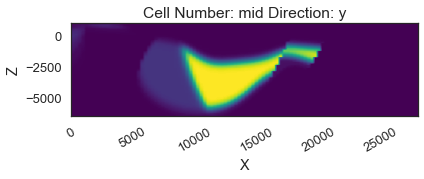

In [34]:
layer = 5
gp.plot_2d(geo_model,
            show_lith=False, show_boundaries=False, show_data=False,
            regular_grid=prob_block[layer],
            kwargs_regular_grid={'cmap': 'viridis',
                                 'norm': None}
            );

In the for-loop above, we not only varied the bottom boundary of the `Lower-filling` unit, but also `Upper-filling` and `Unconformity`. Using the measure of information entropy, we can visualize the parts of the model, where the most change is happening, i.e. where entropy is largest. Black areas in the following plot have zero information entropy, as there is only one "microstate" for the system, i.e. the model ensemble.  

This means, we'd always encounter the same unit at the same place in every ensemble member. The colored areas, however, are areas where we'd encounter different geological units between ensemble members.

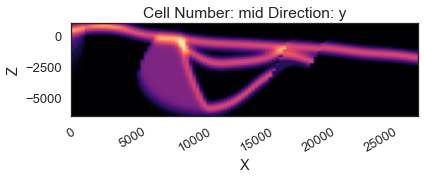

In [35]:
gp.plot_2d(geo_model,
            show_lith=False, show_boundaries=False, show_data=False,
            regular_grid=ie_block,
            kwargs_regular_grid={'cmap': 'magma',
                                 'norm': None}
            );

Finally, let's have a look at the gravity. We'll simply have a look at mean and standard deviation of the simulated gravity of the ensemble:

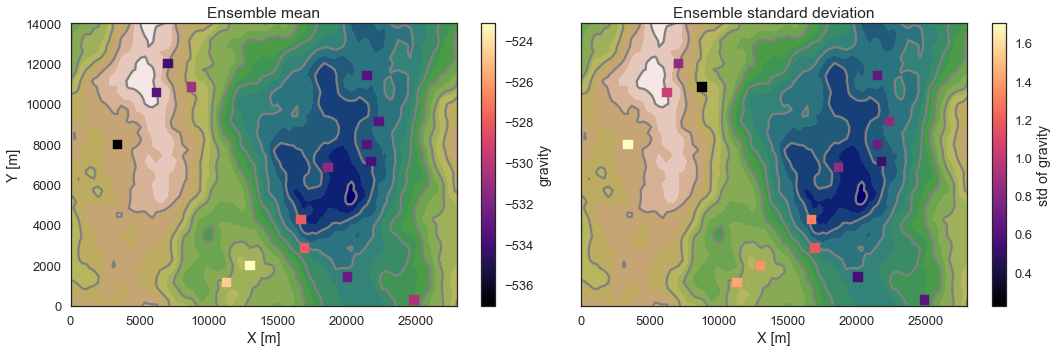

In [66]:
# make subplots with mean and std
gravdf_plt = pd.DataFrame.from_dict(grav)
fig, axs = plt.subplots(1,2, figsize=[15,5], sharey=True)
m_grav = np.mean(gravdf_plt, axis=1)
st_grav = np.std(gravdf_plt, axis=1)

m = axs[0].scatter(grav_stations['X'], grav_stations['Y'], c=m_grav, 
           marker='s', s=90, cmap='magma', zorder=2)
axs[0].contourf(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],20, cmap='gist_earth', zorder=0)
axs[0].contour(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],10, colors='gray', zorder=1)
s = axs[1].scatter(grav_stations['X'], grav_stations['Y'], c=st_grav,
              marker='s', s=90, cmap='magma', zorder=2)
axs[1].contourf(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],20, cmap='gist_earth', zorder=0)
axs[1].contour(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],10, colors='gray', zorder=1)
fig.colorbar(m, ax=axs[0], label='gravity')
fig.colorbar(s, ax=axs[1], label='std of gravity')
axs[0].set_title('Ensemble mean')
axs[1].set_title('Ensemble standard deviation')
axs[0].set_ylabel('Y [m]')
axs[0].set_xlabel('X [m]')
axs[1].set_xlabel('X [m]')


fig.tight_layout()